# Late robustness

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [22]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

g = torch.Generator()
g.manual_seed(seed)


# Data preparation

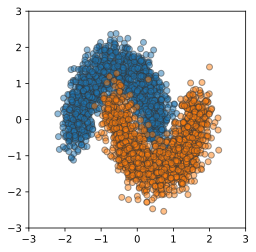

In [23]:
data_noise = 0.2
plotlim = [-3, 3]
subfolder = 'late_rob_moons'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim)


In [24]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[ 0.4784,  0.7730],
        [ 0.1457,  0.5659],
        [ 0.3552, -1.2060],
        [-1.6522,  0.3390],
        [ 1.3732, -0.4984],
        [ 0.4122,  0.6967],
        [ 0.5496,  0.0147],
        [-1.1353,  0.7569],
        [ 0.3197, -1.1625],
        [ 0.4806, -1.4228]]) tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 1])


# Model dynamics

In [25]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, 20 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside



torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

In [26]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [27]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
lnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_lnode = torch.optim.Adam(lnode.parameters(), lr=1e-3) 

# Training and generating level sets

In [28]:
from models.training import doublebackTrainer

num_epochs = 60 #number of optimization runs in which the dataset is used for gradient decent

num_epochs_stage1 = 40
num_epochs_stage2 = num_epochs - num_epochs_stage1

eps = 0.4


trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = eps) 

   
trainer_anode.train(dataloader, num_epochs)

0.4

Iteration 0/45
Loss: 1.137
Robust Term Loss: 0.329
Accuracy: 0.391

Iteration 10/45
Loss: 0.791
Robust Term Loss: 0.258
Accuracy: 0.562

Iteration 20/45
Loss: 0.539
Robust Term Loss: 0.252
Accuracy: 0.703

Iteration 30/45
Loss: 0.421
Robust Term Loss: 0.234
Accuracy: 0.812

Iteration 40/45
Loss: 0.444
Robust Term Loss: 0.247
Accuracy: 0.781
Epoch 1: 0.521
0.4

Iteration 0/45
Loss: 0.341
Robust Term Loss: 0.189
Accuracy: 0.859

Iteration 10/45
Loss: 0.465
Robust Term Loss: 0.265
Accuracy: 0.828

Iteration 20/45
Loss: 0.407
Robust Term Loss: 0.227
Accuracy: 0.797

Iteration 30/45
Loss: 0.363
Robust Term Loss: 0.273
Accuracy: 0.812

Iteration 40/45
Loss: 0.442
Robust Term Loss: 0.282
Accuracy: 0.781
Epoch 2: 0.343
0.4

Iteration 0/45
Loss: 0.292
Robust Term Loss: 0.198
Accuracy: 0.859

Iteration 10/45
Loss: 0.461
Robust Term Loss: 0.291
Accuracy: 0.828

Iteration 20/45
Loss: 0.403
Robust Term Loss: 0.247
Accuracy: 0.812

Iteration 30/45
Loss: 0.355
Robust Term Loss: 0.286
Accuracy: 0

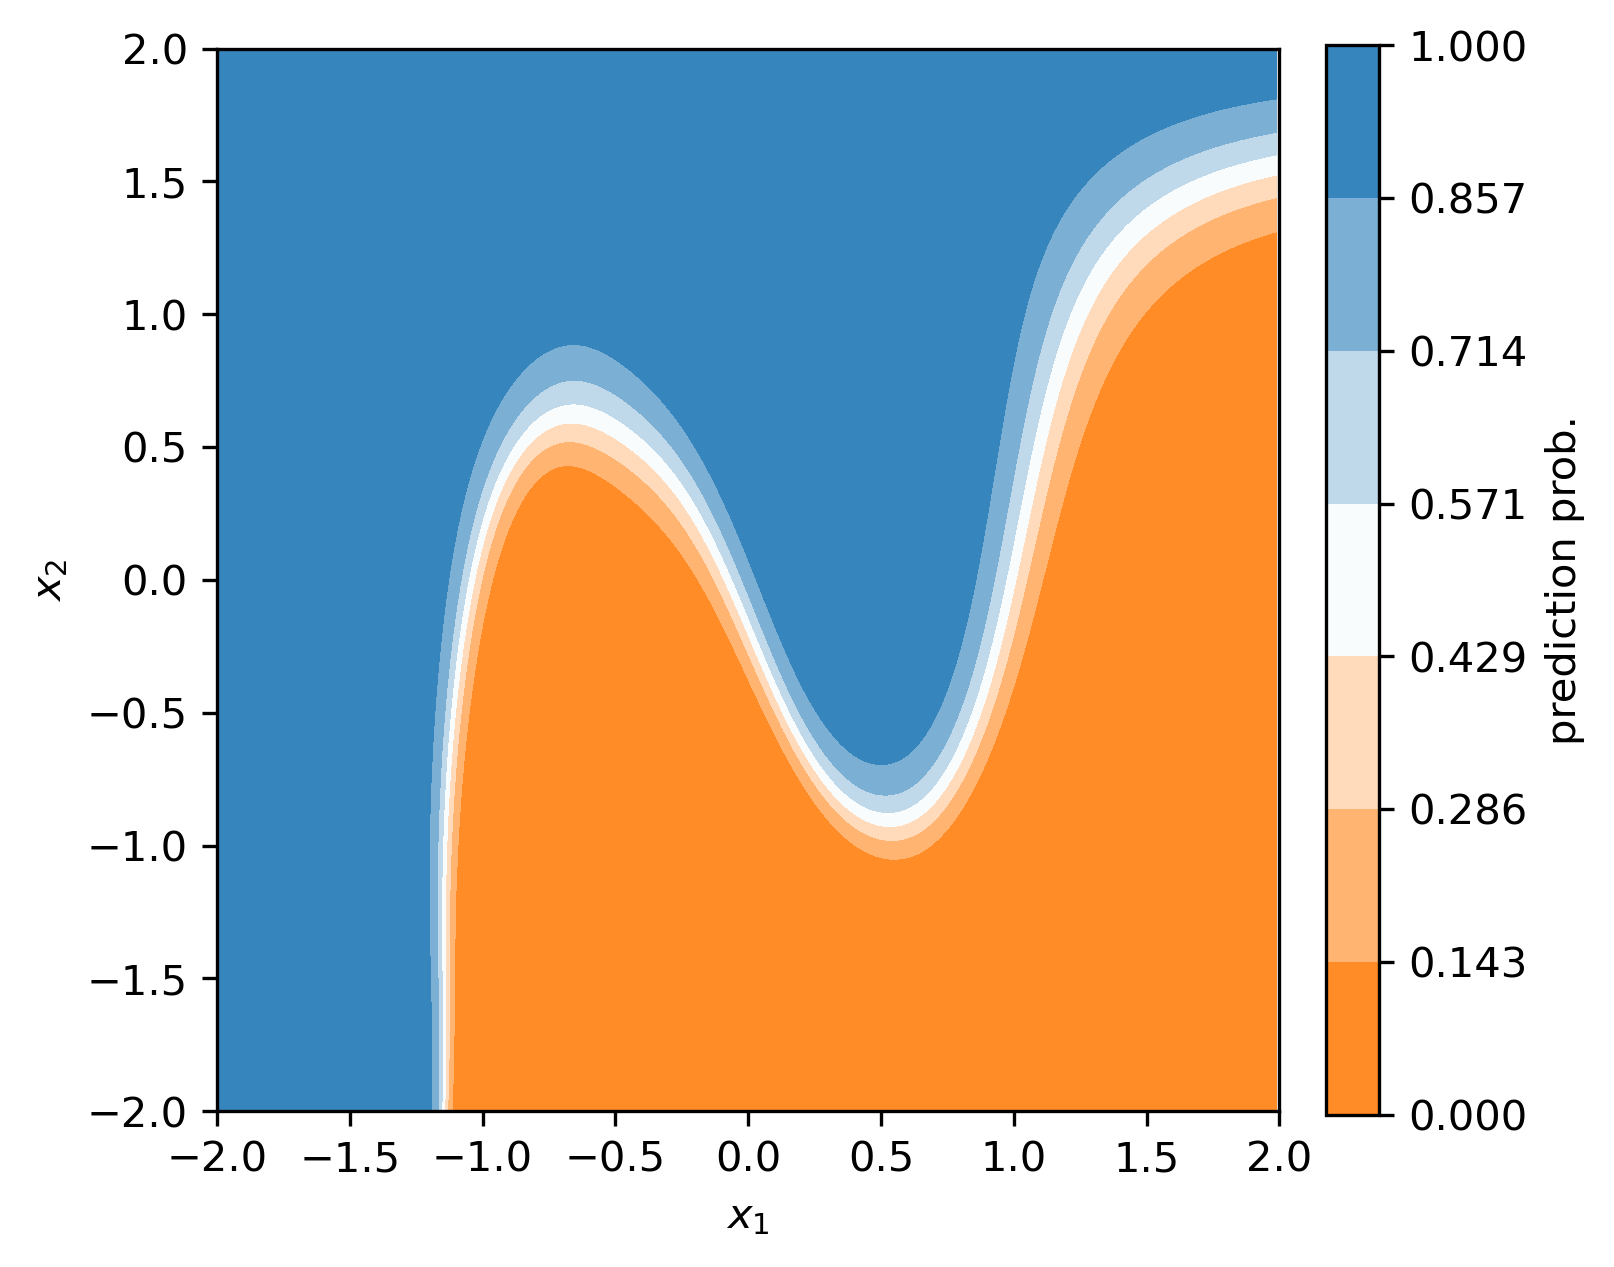

In [29]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
fig_name_base = os.path.join(subfolder, 'levelsets')
classification_levelsets(anode, fig_name_base )
from IPython.display import Image
Image(filename = fig_name_base + '.png', width = 400)

In [30]:
trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, eps_comp = 0) 

   
trainer_rnode.train(dataloader, num_epochs)

0.4

Iteration 0/45
Loss: 1.011
Robust Term Loss: 0.329
Accuracy: 0.391

Iteration 10/45
Loss: 0.717
Robust Term Loss: 0.239
Accuracy: 0.562

Iteration 20/45
Loss: 0.549
Robust Term Loss: 0.218
Accuracy: 0.703

Iteration 30/45
Loss: 0.454
Robust Term Loss: 0.195
Accuracy: 0.781

Iteration 40/45
Loss: 0.470
Robust Term Loss: 0.200
Accuracy: 0.781
Epoch 1: 0.532
0.4

Iteration 0/45
Loss: 0.387
Robust Term Loss: 0.162
Accuracy: 0.859

Iteration 10/45
Loss: 0.508
Robust Term Loss: 0.215
Accuracy: 0.828

Iteration 20/45
Loss: 0.443
Robust Term Loss: 0.184
Accuracy: 0.828

Iteration 30/45
Loss: 0.418
Robust Term Loss: 0.186
Accuracy: 0.812

Iteration 40/45
Loss: 0.463
Robust Term Loss: 0.199
Accuracy: 0.766
Epoch 2: 0.413
0.4

Iteration 0/45
Loss: 0.374
Robust Term Loss: 0.158
Accuracy: 0.875

Iteration 10/45
Loss: 0.507
Robust Term Loss: 0.217
Accuracy: 0.844

Iteration 20/45
Loss: 0.438
Robust Term Loss: 0.183
Accuracy: 0.828

Iteration 30/45
Loss: 0.414
Robust Term Loss: 0.185
Accuracy: 0

In [31]:

 #number of optimization runs in which the dataset is used for gradient decent


trainer_lnode = doublebackTrainer(lnode, optimizer_lnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = eps) 
trainer_lnode.train(dataloader, num_epochs_stage1)
stage_one_histories = trainer_lnode.histories

   

trainer_lnode = doublebackTrainer(lnode, optimizer_lnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, eps_comp = 0.) 
trainer_lnode.train(dataloader, num_epochs_stage2)
stage_two_histories = trainer_lnode.histories

0.4

Iteration 0/45
Loss: 1.137
Robust Term Loss: 0.329
Accuracy: 0.391

Iteration 10/45
Loss: 0.791
Robust Term Loss: 0.258
Accuracy: 0.562

Iteration 20/45
Loss: 0.539
Robust Term Loss: 0.252
Accuracy: 0.703

Iteration 30/45
Loss: 0.421
Robust Term Loss: 0.234
Accuracy: 0.812

Iteration 40/45
Loss: 0.444
Robust Term Loss: 0.247
Accuracy: 0.781
Epoch 1: 0.521
0.4

Iteration 0/45
Loss: 0.341
Robust Term Loss: 0.189
Accuracy: 0.859

Iteration 10/45
Loss: 0.465
Robust Term Loss: 0.265
Accuracy: 0.828

Iteration 20/45
Loss: 0.407
Robust Term Loss: 0.227
Accuracy: 0.797

Iteration 30/45
Loss: 0.363
Robust Term Loss: 0.273
Accuracy: 0.812

Iteration 40/45
Loss: 0.442
Robust Term Loss: 0.282
Accuracy: 0.781
Epoch 2: 0.343
0.4

Iteration 0/45
Loss: 0.292
Robust Term Loss: 0.198
Accuracy: 0.859

Iteration 10/45
Loss: 0.461
Robust Term Loss: 0.291
Accuracy: 0.828

Iteration 20/45
Loss: 0.403
Robust Term Loss: 0.247
Accuracy: 0.812

Iteration 30/45
Loss: 0.355
Robust Term Loss: 0.286
Accuracy: 0

In [32]:
lnode_histories = {}

for key in stage_one_histories.keys():
    lnode_histories[key] = [*stage_one_histories[key], *stage_two_histories[key]]
    
print(len(stage_one_histories['epoch_loss_history']))
print(len(stage_two_histories['epoch_loss_history']))
print(len(lnode_histories['epoch_loss_history']))

40
20
60


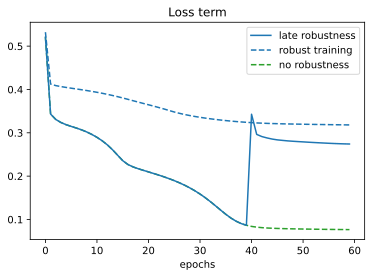

In [33]:
fig_name_base = os.path.join(subfolder, 'loss')

plt.title('Loss term')
plt.plot(lnode_histories['epoch_loss_history'], 'C0')
plt.plot(trainer_rnode.histories['epoch_loss_history'], 'C0--')
plt.plot(trainer_anode.histories['epoch_loss_history'], 'C2--', zorder = -1)
plt.legend(['late robustness', 'robust training', 'no robustness'])
plt.xlabel('epochs')
plt.savefig(fig_name_base + '_total.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()


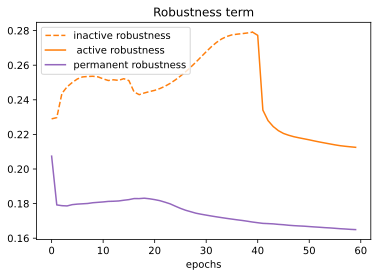

In [34]:
plt.title('Robustness term')
plt.plot(lnode_histories['epoch_loss_rob_history'][0: num_epochs_stage1], 'C1--',)
plt.plot(list(range(num_epochs_stage1 - 1 , num_epochs)),lnode_histories['epoch_loss_rob_history'][num_epochs_stage1 - 1 : num_epochs], 'C1')
plt.plot(trainer_rnode.histories['epoch_loss_rob_history'], 'C4')
plt.xlabel('epochs')
plt.legend(['inactive robustness',' active robustness', 'permanent robustness'])
plt.savefig(fig_name_base + '_robterms.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')


In [40]:
from plots.plots import classification_levelsets
if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
fig_name_base = os.path.join(subfolder, 'levelsets')
fig = classification_levelsets(anode, fig_name_base )
fig_rob = classification_levelsets(rnode, fig_name_base + '_rob')
fig_late = classification_levelsets(lnode, fig_name_base + '_late')


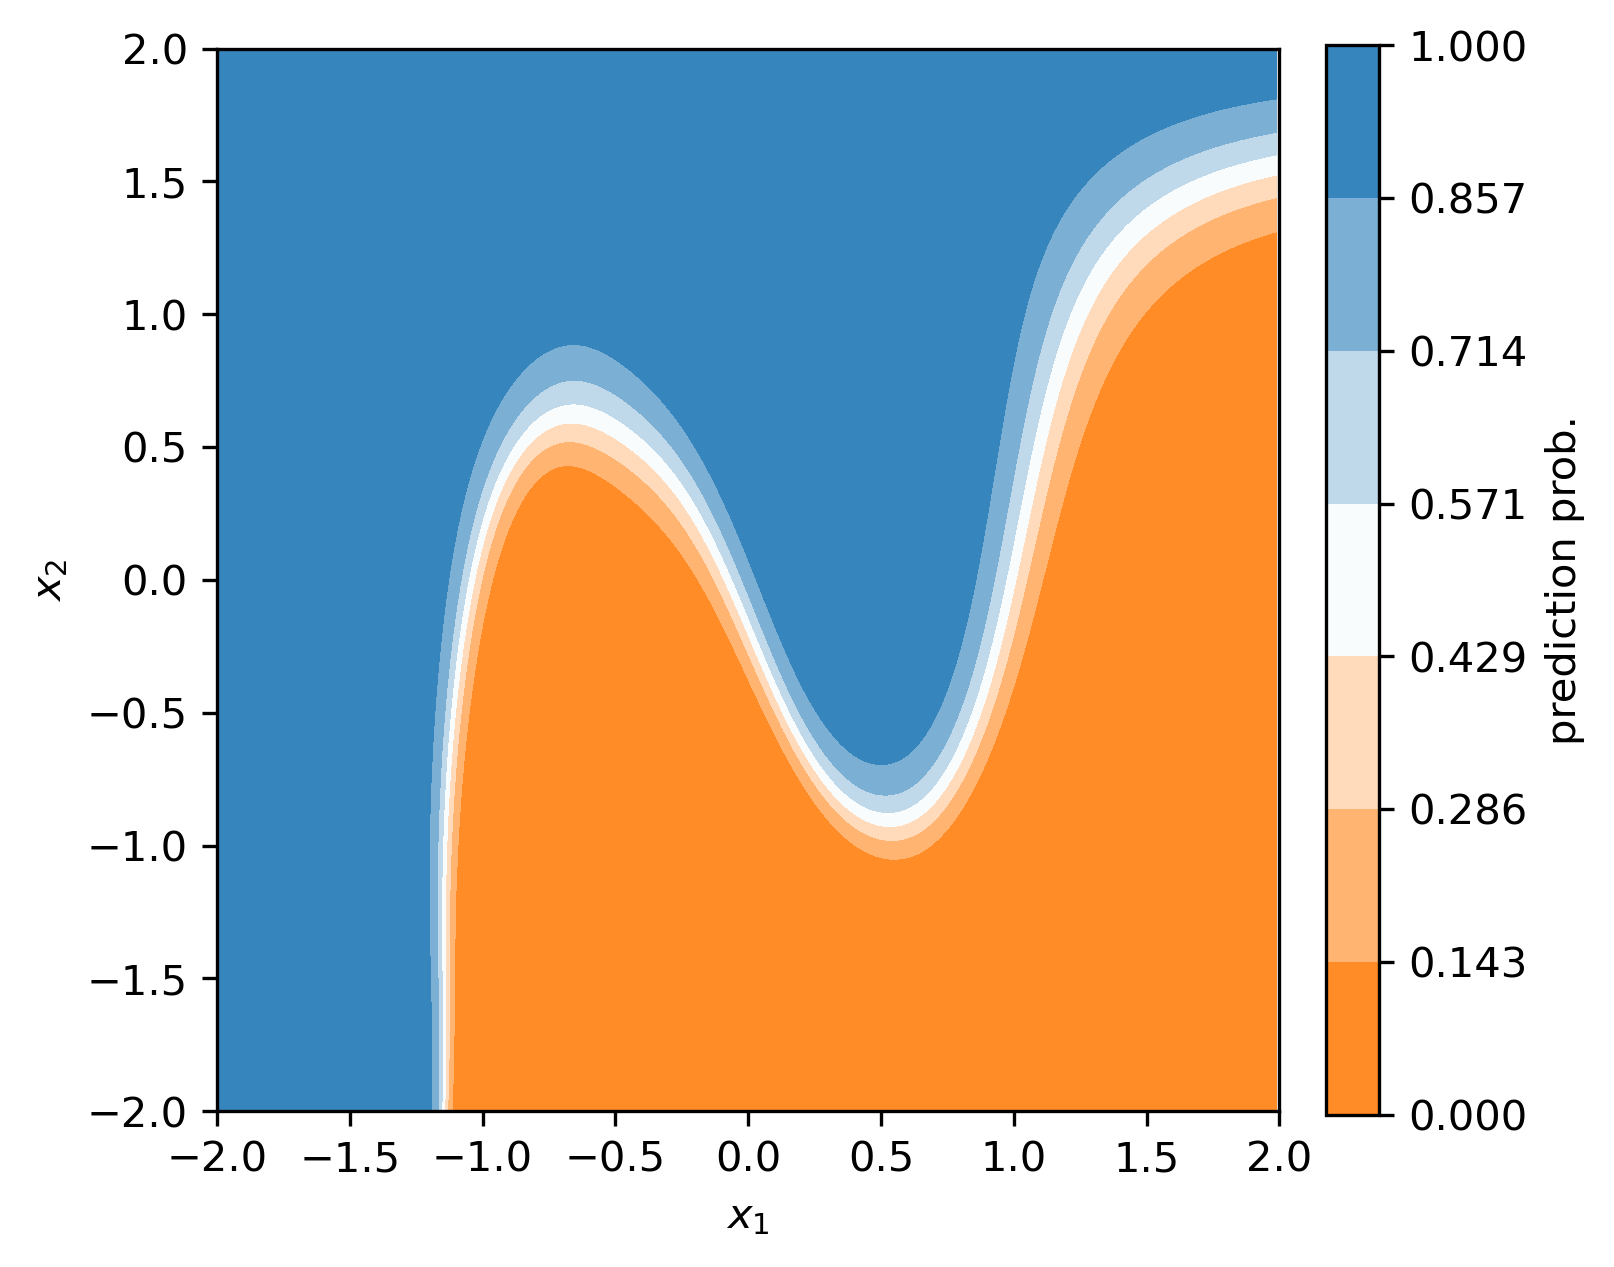

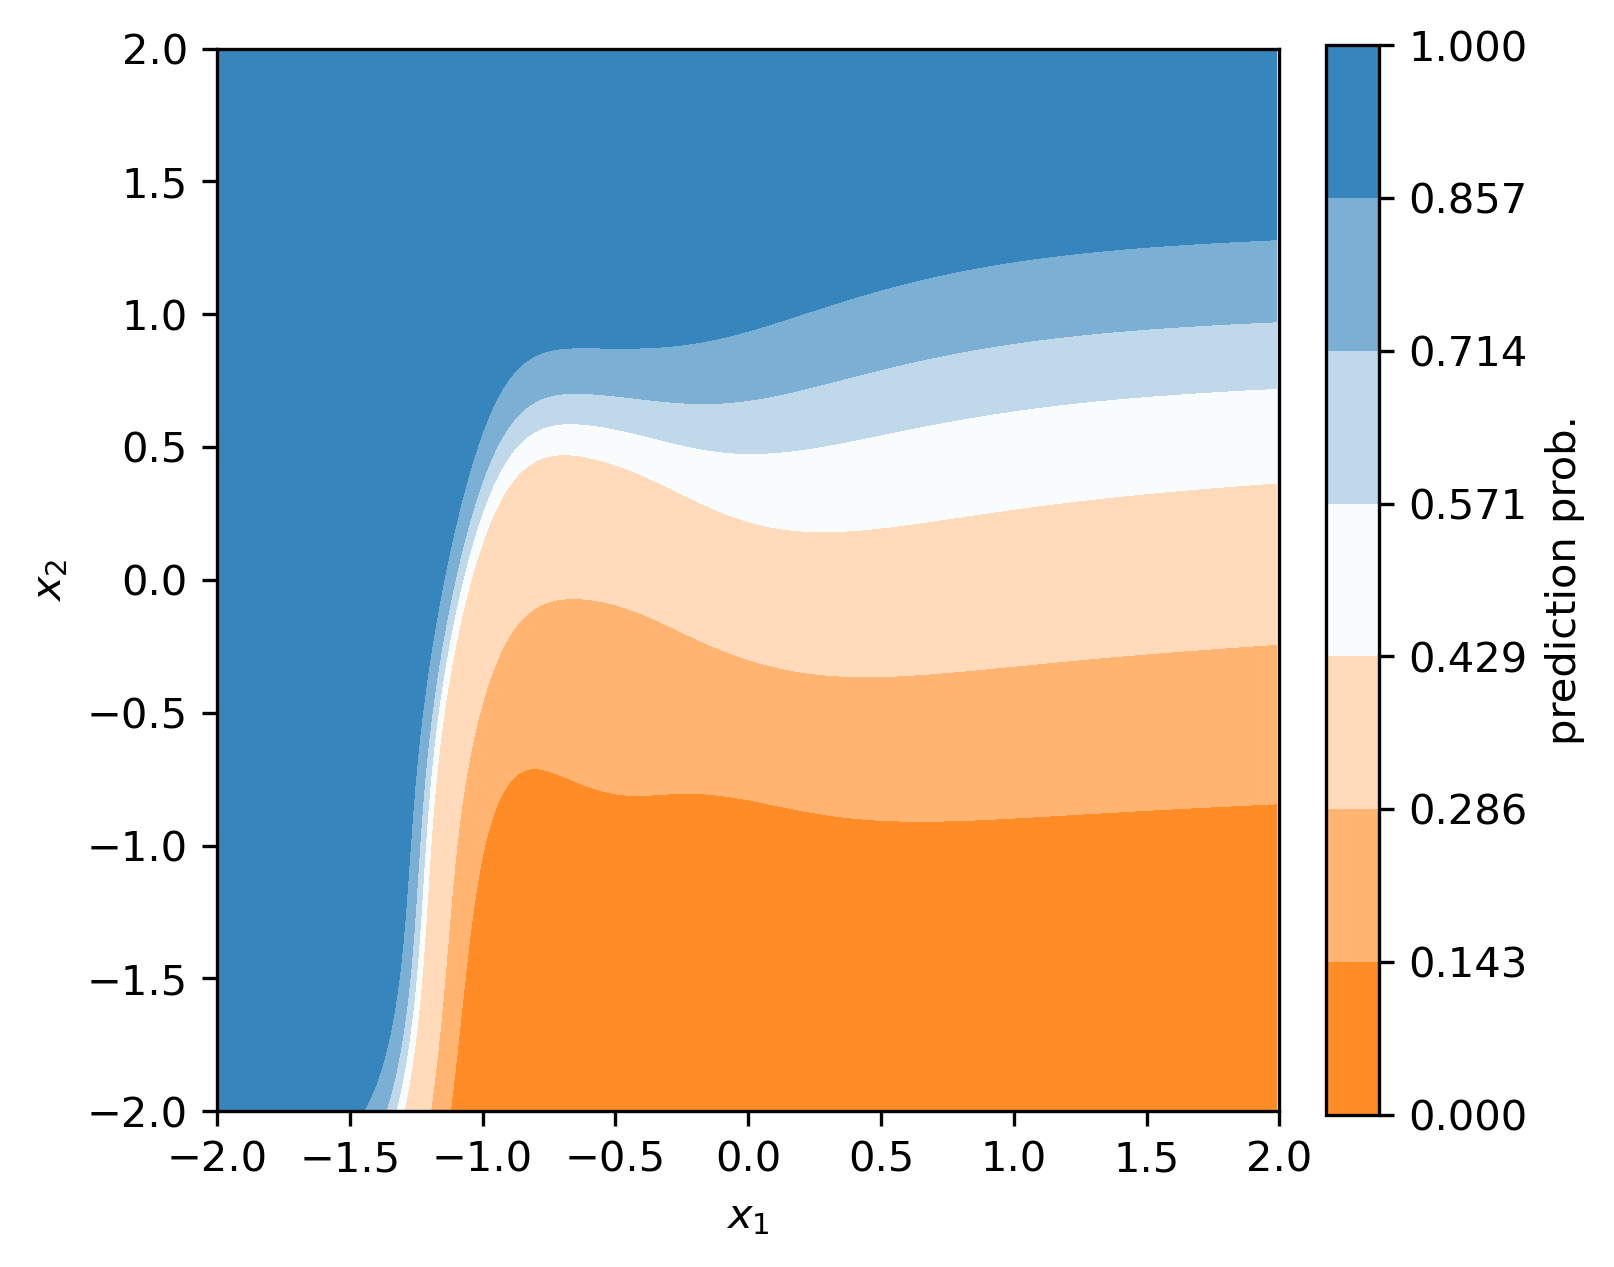

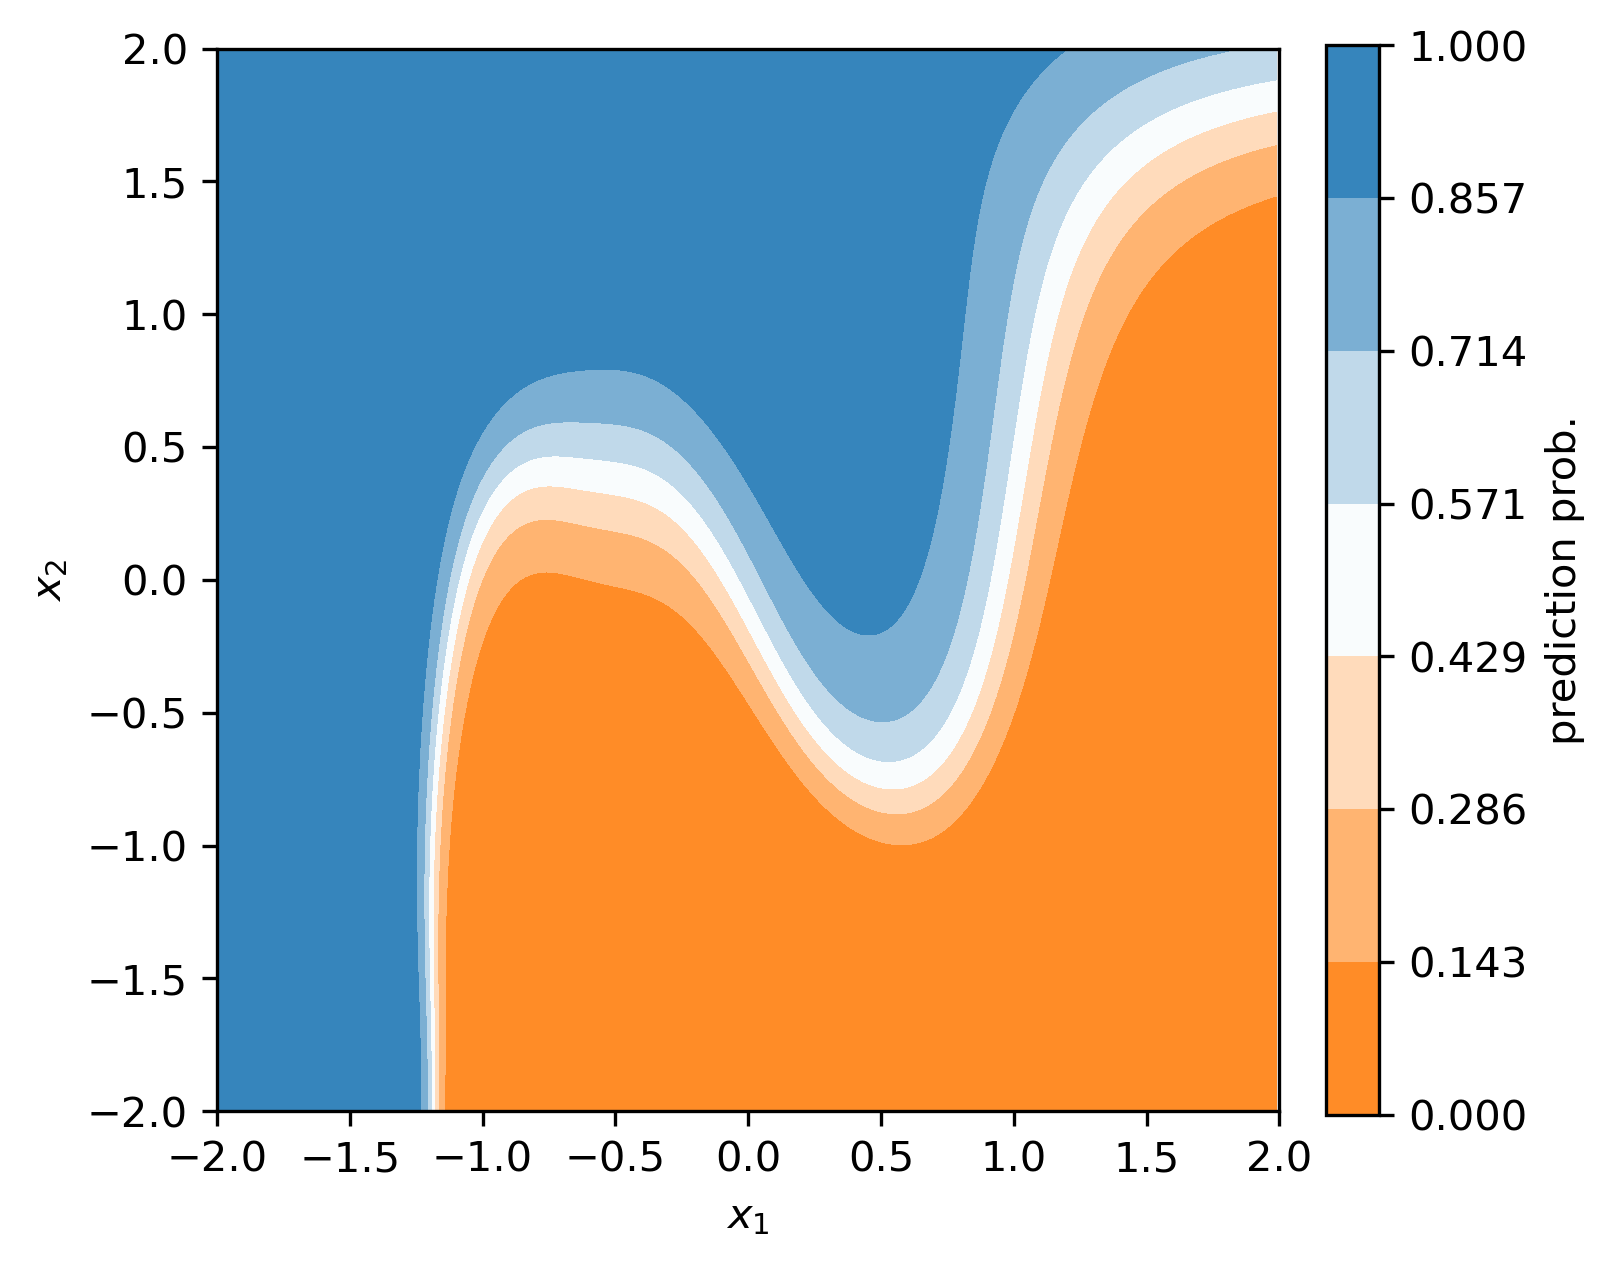

In [41]:
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = fig_name_base + '_rob.png', width = 400)
img3 = Image(filename = fig_name_base + '_late.png', width = 400)

display(img1, img2, img3)

In [42]:
import imageio, os

def comparison_plot(fig1, title1, fig2, title2, fig3, title3, output_file, figsize = (10,3), show = False):

    fig = plt.figure(dpi = 300, figsize=figsize)
    plt.subplot(131)
    sub1 = imageio.imread(fig1)
    plt.imshow(sub1)
    plt.title(title1)
    plt.axis('off')
    plt.tight_layout()
    
    plt.subplot(132)
    sub2 = imageio.imread(fig2)
    plt.imshow(sub2)
    plt.title(title2)
    plt.axis('off')
    
    plt.subplot(133)
    sub3 = imageio.imread(fig3)
    plt.imshow(sub3)
    plt.title(title3)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(output_file, bbox_inches='tight', dpi=600, format='png', facecolor = 'white')
    if show: plt.show()
    else:
        plt.gca()
        plt.close()
    
    return fig

            

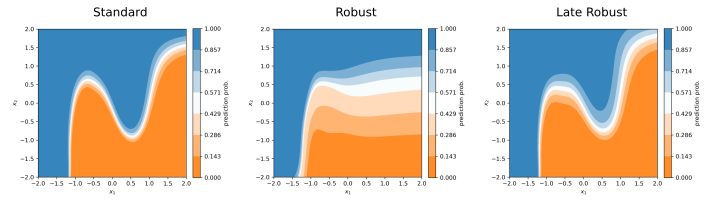

In [43]:
comparison_plot(fig_name_base + '.png', 'Standard', fig_name_base + '_rob.png', 'Robust', fig_name_base + '_late.png', 'Late Robust', fig_name_base + 'classifiers_comp.png')